In [1]:
import sys
import os
#connect local PATH
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))

from CryptoSent.tools import utils as cs


#models
#from CryptoSent.cs_models.finbertlong import fin_bert_long
#from CryptoSent.cs_models.distilbert import distil_bert

In [2]:
p=r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Main Dataset\submissions.pickle'
df=pd.read_pickle(p)

In [3]:
df=df[df.subreddit=='Bitcoin']
df=df.sort_values(by='score',ascending=False)
top=df.head(10000)

In [4]:
from CryptoSent.cs_models.distilbert import distil_bert_df,distil_bert

In [5]:
top=distil_bert_df(top,'title','sentiment')

100%|██████████| 10000/10000 [03:59<00:00, 41.82it/s]
C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\cs_models\distilbert.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_db']=df[text].progress_apply(lambda x: distil_bert(x,output=output_type))


In [138]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime

In [92]:
from CryptoSent.tools.crypto_coin_actual import get_btc_actual
q=get_btc_actual()
q['datetime']=pd.to_datetime(q.unix.progress_apply(cs.date_parser_utc))
q=q.set_index('datetime')
q['avg_hl']=(q.high+q.low)/2
q['avg_oc']=(q.open+q.close)/2

100%|██████████| 30907/30907 [00:00<00:00, 146345.91it/s]


In [135]:
def get_ts_2axis(sent,btc,resample_period='w',btc_transformation='diff'):

    sdmin=datetime.strftime(sent.index.min(),'%Y-%m-%d')
    sdmax=datetime.strftime(sent.index.max(),'%Y-%m-%d')
    
    sent=sent.resample(resample_period).sum()
    btc=btc[sdmin:sdmax].resample(resample_period).mean()
    
  
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(
        go.Scatter(x=sent.index, y=sent, name="Sentiment"),
        secondary_y=False,
    )

    if btc_transformation=='diff':
        fig.add_trace(
            go.Scatter(x=btc.index, y=btc.diff(), name="Bitcoin Avg"),
            secondary_y=True,
        )

    if btc_transformation=='pct_change':
        fig.add_trace(
            go.Scatter(x=btc.index, y=btc.pct_change(), name="Bitcoin Avg"),
            secondary_y=True,
        )
    # Add figure title
    fig.update_layout(
        title_text=f"BTC vs Sentiment - Resample ({resample_period})"
    )

    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Sentiment  </b>", secondary_y=False)
    fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

    fig.show()

In [136]:
get_ts_2axis(top.sent_db,q.avg_hl,'d','pct_change')


# Granger Causality

In [171]:
from statsmodels.tsa.stattools import grangercausalitytests

In [401]:
resample_period='10h'
def res_proc(sentiment,coin_price,resample_period='d'):
    sdmin=datetime.strftime(sentiment.index.min(),'%Y-%m-%d')
    sdmax=datetime.strftime(sentiment.index.max(),'%Y-%m-%d')
    sent=sentiment.resample(resample_period).sum()
    btc=coin_price[sdmin:sdmax].resample(resample_period).mean()
    merres=pd.concat([sent,btc],axis=1)
    merres.loc[:,'avg_hl_diff']=merres.avg_hl.diff()
    merres.loc[:,'avg_hl_pct_change']=merres.avg_hl.pct_change()
    merres.loc[:,'sent_db_shift']=merres.sent_db.shift(1)
    merres.loc[:,'sent_db_ptc_change']=merres.sent_db.pct_change()
    return merres

In [402]:
res_proc(top.sent_db,q.avg_hl,resample_period='d')

,sent_db,avg_hl,avg_hl_diff,avg_hl_pct_change,sent_db_shift,sent_db_ptc_change
2019-01-01,1.893235,3696.113958,NaN,NaN,NaN,NaN
2019-01-02,-0.313565,3820.308333,124.194375,0.033601,1.893235,-1.165624
2019-01-03,-0.483061,3833.273958,12.965625,0.003394,-0.313565,0.540546
2019-01-04,-7.301582,3784.448333,-48.825625,-0.012737,-0.483061,14.115242
2019-01-05,2.686618,3835.858125,51.409792,0.013584,-7.301582,-1.367950
...,...,...,...,...,...,...
2021-06-26,-6.370576,31499.903333,-2098.342500,-0.062454,-0.443458,13.365688
2021-06-27,-2.299010,32849.404583,1349.501250,0.042841,-6.370576,-0.639121
2021-06-28,-9.554917,34465.523750,1616.119167,0.049198,-2.299010,3.156101
2021-06-29,-11.920851,35427.257917,961.734167,0.027904,-9.554917,0.247614


In [383]:
inm=merres[['sent_db','avg_hl_pct_change']].dropna()

In [384]:
merres

,sent_db,avg_hl,avg_hl_diff,avg_hl_pct_change,sent_db_shift,sent_db_ptc_change
2019-01-01 00:00:00,1.005502,3690.83000,NaN,NaN,NaN,NaN
2019-01-01 10:00:00,-0.008163,3695.64100,4.81100,0.001304,1.005502,-1.008119
2019-01-01 20:00:00,-1.053100,3763.22550,67.58450,0.018288,-0.008163,128.003645
2019-01-02 06:00:00,-0.998759,3805.42800,42.20250,0.011214,-1.053100,-0.051601
2019-01-02 16:00:00,-0.331310,3862.14950,56.72150,0.014905,-0.998759,-0.668279
...,...,...,...,...,...,...
2021-06-29 00:00:00,-2.948394,34700.70150,249.88300,0.007253,-7.664715,-0.615329
2021-06-29 10:00:00,-6.003692,35810.89350,1110.19200,0.031993,-2.948394,1.036259
2021-06-29 20:00:00,-3.942682,35994.96350,184.07000,0.005140,-6.003692,-0.343290
2021-06-30 06:00:00,-0.586439,34825.60900,-1169.35450,-0.032487,-3.942682,-0.851259


In [388]:
maxlag=5

def get_granger_causality(data, test='ssr_chi2test', verbose=False):

    #gc_test=['ssr_ftest','ssr_chi2test','lrtest','params_ftest'] 
    psave=[]
    cols=[]
    variables=data.columns
    df = pd.DataFrame(np.zeros((maxlag,len(variables))), columns=variables)
    for c in df.columns:
        for r in df.columns:
            if c!=r:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                cols.append(f'Y_{r}__X_{c}')
                psave.append(p_values)
    df=pd.DataFrame(np.array(psave).T,columns=cols)
    return df

In [389]:
glogg=grangers_causation(inm)

<AxesSubplot:>

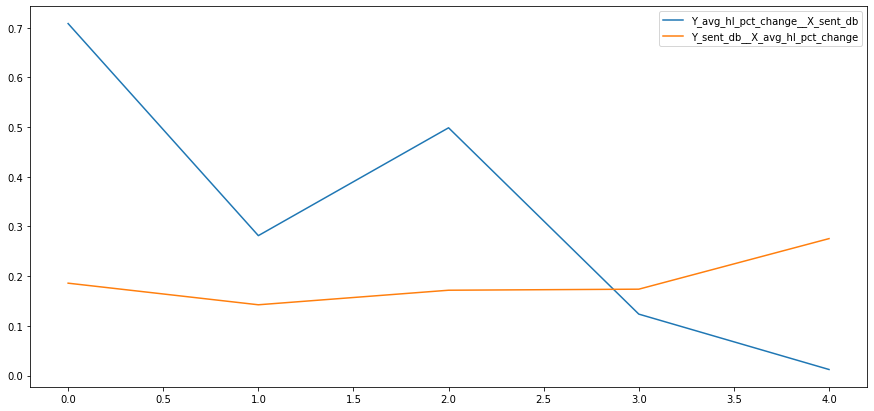

In [390]:
glogg.plot(figsize=(15,7))

# Normalization

In [396]:
df

,author,num_comments,score,title,selftext,award_name,award_description,award_count,award_coin_price,award_coin_reward,...,id,domain,no_follow,send_replies,author_fullname,subreddit_id,permalink,url,created,author_created
created,,,,,,,,,,,,,,,,,,,,,
2021-02-08 13:48:45,AlphaGrayWolf,2954,45445,Tesla buys $1.5b in Bitcoin and is looking to ...,NaN,"(Wholesome Seal of Approval, All-Seeing Upvote...","(A glittering stamp for a feel-good thing, A g...","(1, 5, 1, 1, 1, 3, 1, 3, 3, 3, 36, 31, 56, 1, ...","(30, 30, 20, 20, 250, 75, 1800, 500, 500, 325,...","(0, 0, 0, 0, 100, 100, 0, 100, 100, 0, 0, 0, 0...",...,lfb3mm,v.redd.it,False,True,t2_u4c9x3c,t5_2s3qj,/r/Bitcoin/comments/lfb3mm/tesla_buys_15b_in_b...,https://v.redd.it/gazga81l29g61,2021-02-08 13:48:45,2018-01-27 23:07:31
2021-01-28 17:11:32,Secret_Operative,1569,39940,Robinhood just blocked several stocks from bei...,Anyone following the WSB drama this morning wi...,"(Take My Power, Bravo Grande!, Wholesome Seal ...","(Add my power to yours., For an especially ama...","(1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 21,...","(75, 75, 30, 30, 30, 20, 20, 200, 300, 75, 500...","(0, 0, 0, 0, 0, 0, 0, 0, 250, 100, 100, 0, 0, ...",...,l70vrq,self.Bitcoin,False,False,t2_7apecu5u,t5_2s3qj,/r/Bitcoin/comments/l70vrq/robinhood_just_bloc...,https://www.reddit.com/r/Bitcoin/comments/l70v...,2021-01-28 17:11:32,2020-07-16 17:16:15
2019-07-24 20:24:16,khaotickk,586,36690,"Quick, upvote this to confuse everyone into th...",NaN,"(Gold, Silver)","(Gives the author a week of Reddit Premium, %{...","(2, 3)","(500, 100)","(100, 0)",...,chbx9d,i.redd.it,False,True,t2_adaoe,t5_2s3qj,/r/Bitcoin/comments/chbx9d/quick_upvote_this_t...,https://i.redd.it/pcioshemnac31.gif,2019-07-24 20:24:16,2013-01-26 09:07:51
2021-05-19 13:50:39,winklebone,1177,24236,I don't care cat,NaN,"(Party Train, Helpful (Pro), Gold, Blow a Kiss...",(All aboard! Every five Party Train Awards giv...,"(3, 1, 6, 1, 7, 51, 49, 1, 49, 3, 43, 1)","(75, 500, 500, 300, 250, 150, 125, 125, 100, 1...","(100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0)",...,ng3otr,v.redd.it,False,True,t2_10u48d,t5_2s3qj,/r/Bitcoin/comments/ng3otr/i_dont_care_cat/,https://v.redd.it/zkdh1j8jf2071,2021-05-19 13:50:39,2016-08-24 10:29:24
2021-01-03 11:11:54,Ribtin,1381,22629,I just sold,I'm up more than 110x so I just sold a chunk a...,"(Narwhal Salute, All-Seeing Upvote, Gold, Brav...","(A golden splash of respect, A glowing commend...","(1, 1, 2, 2, 1, 22, 20, 1, 27, 16, 1, 16, 1)","(30, 30, 500, 400, 350, 300, 150, 150, 125, 10...","(0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",...,kpi6pa,self.Bitcoin,False,True,t2_911j,t5_2s3qj,/r/Bitcoin/comments/kpi6pa/i_just_sold/,https://www.reddit.com/r/Bitcoin/comments/kpi6...,2021-01-03 11:11:54,2006-06-30 08:41:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-11 05:16:17,[deleted],6,0,Stupid question,[deleted],Empty,Empty,Empty,Empty,Empty,...,m2hk80,self.Bitcoin,True,True,NaN,t5_2s3qj,/r/Bitcoin/comments/m2hk80/stupid_question/,https://www.reddit.com/r/Bitcoin/comments/m2hk...,2021-03-11 05:16:17,NaT
2021-03-11 05:16:06,coolestbat,9,0,What will happen if everyone started selling t...,Sounds absurd but I was puzzled when this thou...,Empty,Empty,Empty,Empty,Empty,...,m2hk48,self.Bitcoin,True,True,t2_a9vno9k4,t5_2s3qj,/r/Bitcoin/comments/m2hk48/what_will_happen_if...,https://www.reddit.com/r/Bitcoin/comments/m2hk...,2021-03-11 05:16:06,2021-02-10 10:31:33
2021-03-11 05:12:07,squidward4comminism,1,0,Bolivar technical college; aka BTC This HAS TO...,NaN,Empty,Empty,Empty,Empty,Empty,...,m2hhoi,bolivarcollege.edu,True,True,t2_2urcgmu0,t5_2s3qj,/r/Bitcoin/comments/m2hhoi/bolivar_technical_c...,https://www.bolivarcollege.edu/,2021-03-11 05:12:07,2018-12-25 18:03:27


In [66]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [83]:
print('Negative')
adf_test(a.neg)
print('Positive')
adf_test(a.pos)
print('Neutural')
adf_test(a.neut)

Negative
ADF Statistics: -1.601826
p-value: 0.482676
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Positive
ADF Statistics: -1.041458
p-value: 0.737845
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Neutural
ADF Statistics: -1.626460
p-value: 0.469344
Critical values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [67]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
maxlag=15
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [205]:
grangercausalitytests(qq[['sent','avg_price']],maxlag=30)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1
ssr based chi2 test:   chi2=4.0391  , p=0.0445  , df=1
likelihood ratio test: chi2=4.0250  , p=0.0448  , df=1
parameter F test:         F=4.0181  , p=0.0455  , df_denom=576, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2
ssr based chi2 test:   chi2=9.5235  , p=0.0086  , df=2
likelihood ratio test: chi2=9.4459  , p=0.0089  , df=2
parameter F test:         F=4.7206  , p=0.0093  , df_denom=573, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3
ssr based chi2 test:   chi2=15.1550 , p=0.0017  , df=3
likelihood ratio test: chi2=14.9594 , p=0.0019  , df=3
parameter F test:         F=4.9904  , p=0.0020  , df_denom=570, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.3331  , p=0.0018  

{1: ({'ssr_ftest': (4.018140372321272, 0.045480892850057714, 576.0, 1),
   'ssr_chi2test': (4.039068186760446, 0.04445836315493673, 1),
   'lrtest': (4.025045219636695, 0.04482941805634296, 1),
   'params_ftest': (4.01814037232121, 0.045480892850057714, 576.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.720558715059396, 0.009259629895419029, 573.0, 2),
   'ssr_chi2test': (9.523500653767298, 0.008550629894432563, 2),
   'lrtest': (9.445894286733619, 0.008888942918187894, 2),
   'params_ftest': (4.7205587150591715, 0.009259629895421093, 573.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.990389957724367, 0.0020043815893312175, 570.0, 3),
   'ssr_chi2test': (15.155026345299786, 0.0016888480801433856, 3),
   'lrtest': (14.959419085284026, 0.0018516585883349705, 3),
   'params_ftest': (4.9903899577224715, 0.0020043815893365405, 570.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
      

In [210]:
grangercausalitytests(qq[['avg_price','sent']],maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1
ssr based chi2 test:   chi2=0.0506  , p=0.8220  , df=1
likelihood ratio test: chi2=0.0506  , p=0.8220  , df=1
parameter F test:         F=0.0503  , p=0.8226  , df_denom=576, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2
ssr based chi2 test:   chi2=0.3686  , p=0.8317  , df=2
likelihood ratio test: chi2=0.3685  , p=0.8317  , df=2
parameter F test:         F=0.1827  , p=0.8331  , df_denom=573, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3
ssr based chi2 test:   chi2=0.4152  , p=0.9371  , df=3
likelihood ratio test: chi2=0.4150  , p=0.9371  , df=3
parameter F test:         F=0.1367  , p=0.9381  , df_denom=570, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0765  , p=0.9894  

{1: ({'ssr_ftest': (0.05032801906798377, 0.8225730298922472, 576.0, 1),
   'ssr_chi2test': (0.050590144167296194, 0.822039542499774, 1),
   'lrtest': (0.05058793413627427, 0.8220433645373284, 1),
   'params_ftest': (0.05032801906797866, 0.8225730298922472, 576.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.18269829147234973, 0.8330679531311422, 573.0, 2),
   'ssr_chi2test': (0.36858503480285565, 0.8316924837165998, 2),
   'lrtest': (0.36846756317754625, 0.8317413352851639, 2),
   'params_ftest': (0.1826982914724184, 0.8330679531311156, 573.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.13670726540128597, 0.9380996254208237, 570.0, 3),
   'ssr_chi2test': (0.41515837966601055, 0.9370936313656199, 3),
   'lrtest': (0.41500909556816623, 0.9371248100067849, 3),
   'params_ftest': (0.13670726540125208, 0.9380996254208368, 570.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

In [130]:
# x and y given as array_like objects
import plotly.express as px
fig = px.scatter(ga, x=ga.avg_price.values, y=ga.neg.values)
fig.show()

In [159]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=ga.avg_price, y=ga.pos, name="Positive",mode='markers'),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(x=ga.avg_price, y=ga.neg, name="Negative",mode='markers'),
    secondary_y=False,
)

# Add traces
fig.add_trace(
    go.Scatter(x=ga.avg_price, y=ga.sent, name="Sentiment",mode='markers'),
    secondary_y=False,
)

In [194]:
sent_roll_period =0
sent_rollback=pd.DataFrame(ga.sent).reset_index()
sent_rollback.index=pd.DatetimeIndex(sent_rollback.Date)-pd.DateOffset(sent_roll_period)

sent_rollback=sent_rollback.drop(columns='Date')
sent_rollback=sent_rollback.merge(btc,left_index=True, right_index=True)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(
    autosize=False,
    width=1700,
    height=800,)
# Add traces
fig.add_trace(
    go.Scatter(x=sent_rollback.avg_price, y=sent_rollback.sent, name="Positive",mode='markers'),
    secondary_y=False,
)




# Title + Body

In [4]:
import numpy as np

In [5]:
df.award_count=df.award_count.replace('Empty',0)
df.award_coin_price=df.award_coin_price.replace('Empty',0)
df['kpi1']=df.apply(lambda row: row['award_count']*row['award_coin_price'] if type(row['award_count'])==int
                                        else sum(np.multiply(np.array(list(row['award_count'])),np.array(list(row['award_coin_price'])))),axis=1)

In [7]:
top_authors=df[df.author!='[deleted]'].sort_values(by='kpi1',ascending=False).head(1000).author.unique().tolist()

In [23]:
s=df[df.author.isin(top_authors)]
s.selftext=s.selftext.fillna(' ')
s.title=s.title.fillna(' ')
s['all_text']=s.title+' '+s.selftext

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
s['all_text_capped']=s.all_text.apply(lambda x: ' '.join(x.split()[:140]))

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
s['distil_bert']=s.title.progress_apply(cm.distil_bert)

100%|██████████| 16227/16227 [06:17<00:00, 42.96it/s]
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
s['fin_bert']=s.title.progress_apply(cm.fin_bert)

100%|██████████| 16227/16227 [13:03<00:00, 20.72it/s]
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
s['pos']=s.fin_bert.apply(lambda x: x[0])
s['neg']=s.fin_bert.apply(lambda x: x[1])
s['neut']=s.fin_bert.apply(lambda x: x[2])

s['neg_distil']=s.distil_bert.apply(lambda x: x[0])
s['post_distil']=s.distil_bert.apply(lambda x: x[1])
top=s.copy()

C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

<AxesSubplot:xlabel='created'>

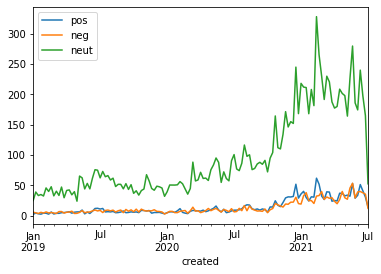

In [60]:
top[['pos','neg','neut']].resample('w').sum().plot()

<AxesSubplot:xlabel='created'>

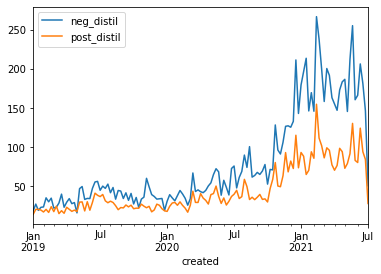

In [58]:
top[['neg_distil','post_distil']].resample('w').sum().plot()

In [51]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [187]:
dchunk='d'
a=top.resample(dchunk).sum()[['neg','pos','neut']]
btc_price=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\coin_Bitcoin.csv")
btc_price.Date=pd.to_datetime(btc_price.Date)
btc_price=btc_price.set_index('Date')
btc_price['avg_price']=(btc_price.High+btc_price.Low)/2

btc_price_avg=btc_price.resample(dchunk).mean().loc['2019':'2021-06']['avg_price']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])



fig.add_trace(
    go.Scatter(x=a.index, y=(a.pos-a.neg), name="FinBert Sentiment"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=btc_price_avg.index, y=btc_price_avg.diff(), name="Bit Coin Avg"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="BTC vs Sentiment Model "
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Polarity </b>", secondary_y=False)
fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

fig.show()

In [188]:
btc=btc_price_avg.diff().dropna()

In [196]:
gc=pd.concat([btc,
((top.post_distil-top.neg_distil).resample('d').sum()).rename('distil_bert'),
(a.pos-a.neg).tail(-1).rename('fin_bert')],axis=1).dropna()

In [203]:
(a.pos-a.neg).rename('fin_bert')

created
2019-01-01   -0.390011
2019-01-02   -3.064867
2019-01-03   -0.000574
2019-01-04   -0.054681
2019-01-05    0.376955
                ...   
2021-06-26   -1.671397
2021-06-27   -2.057088
2021-06-28   -0.038014
2021-06-29   -2.449407
2021-06-30    4.744237
Freq: D, Name: fin_bert, Length: 912, dtype: float64

In [197]:
gc

,avg_price,distil_bert,fin_bert
2019-01-02,103.622851,-2.986790,-3.064867
2019-01-03,-1.741384,0.730157,-0.000574
2019-01-04,-56.059902,0.933188,-0.054681
2019-01-05,46.007512,-0.163784,0.376955
2019-01-06,89.003642,-1.866696,-0.337447
...,...,...,...
2021-06-26,-2008.021437,-8.237820,-1.671397
2021-06-27,1952.897758,-9.218547,-2.057088
2021-06-28,1197.041590,-11.315186,-0.038014
2021-06-29,836.314113,-10.208426,-2.449407


In [198]:
grangercausalitytests(gc[['fin_bert','avg_price']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=45.9003 , p=0.0000  , df_denom=907, df_num=1
ssr based chi2 test:   chi2=46.0521 , p=0.0000  , df=1
likelihood ratio test: chi2=44.9247 , p=0.0000  , df=1
parameter F test:         F=45.9003 , p=0.0000  , df_denom=907, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=24.1487 , p=0.0000  , df_denom=904, df_num=2
ssr based chi2 test:   chi2=48.5645 , p=0.0000  , df=2
likelihood ratio test: chi2=47.3117 , p=0.0000  , df=2
parameter F test:         F=24.1487 , p=0.0000  , df_denom=904, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=17.9103 , p=0.0000  , df_denom=901, df_num=3
ssr based chi2 test:   chi2=54.1484 , p=0.0000  , df=3
likelihood ratio test: chi2=52.5953 , p=0.0000  , df=3
parameter F test:         F=17.9103 , p=0.0000  , df_denom=901, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.3204 , p=0.0000  

In [199]:
grangercausalitytests(gc[['avg_price','fin_bert']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0256  , p=0.8729  , df_denom=907, df_num=1
ssr based chi2 test:   chi2=0.0257  , p=0.8726  , df=1
likelihood ratio test: chi2=0.0257  , p=0.8726  , df=1
parameter F test:         F=0.0256  , p=0.8729  , df_denom=907, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8538  , p=0.0080  , df_denom=904, df_num=2
ssr based chi2 test:   chi2=9.7612  , p=0.0076  , df=2
likelihood ratio test: chi2=9.7092  , p=0.0078  , df=2
parameter F test:         F=4.8538  , p=0.0080  , df_denom=904, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6809  , p=0.0118  , df_denom=901, df_num=3
ssr based chi2 test:   chi2=11.1286 , p=0.0111  , df=3
likelihood ratio test: chi2=11.0609 , p=0.0114  , df=3
parameter F test:         F=3.6809  , p=0.0118  , df_denom=901, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6502  , p=0.0321  

In [136]:
print('Negative')
adf_test(a.neg)
print('Positive')
adf_test(a.pos)
print('Neutural')
adf_test(a.neut)

Negative
ADF Statistics: 0.658092
p-value: 0.988963
Critical values:
	1%: -3.487
	5%: -2.886
	10%: -2.580
Positive
ADF Statistics: -0.634765
p-value: 0.862931
Critical values:
	1%: -3.485
	5%: -2.885
	10%: -2.579
Neutural
ADF Statistics: -0.875673
p-value: 0.795878
Critical values:
	1%: -3.485
	5%: -2.885
	10%: -2.579


In [137]:

from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('KPSS Test: Apple time series')
kpss_test(a['pos'])
print('KPSS Test: Walmart time series')
kpss_test(a['neg'])
print('KPSS Test: Tesla time series')
kpss_test(a['neut'])

KPSS Test: Apple time series
KPSS Statistic: 1.4822883362170491
p-value: 0.01
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Walmart time series
KPSS Statistic: 1.429694166443776
p-value: 0.01
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Tesla time series
KPSS Statistic: 1.5218360017886652
p-value: 0.01
num lags: 6
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\statsmodels\tsa\stattools.py:2012: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [179]:
sdf=top[top.score>200]

<AxesSubplot:xlabel='created'>

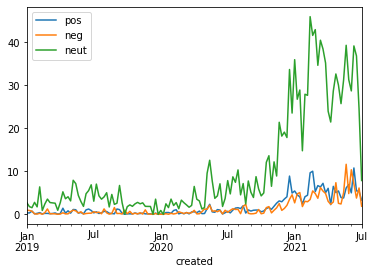

In [181]:
sdf[['pos','neg','neut']].resample('w').sum().plot()

<AxesSubplot:xlabel='created'>

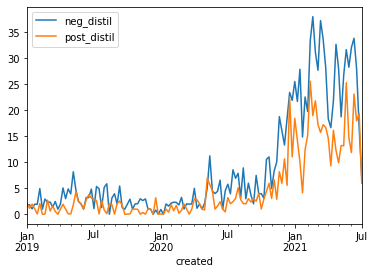

In [182]:
sdf[['neg_distil','post_distil']].resample('w').sum().plot()

In [183]:
dchunk='w'
a=sdf.resample(dchunk).sum()[['neg','pos','neut']]
btc_price=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\other\coin_Bitcoin.csv")
btc_price.Date=pd.to_datetime(btc_price.Date)
btc_price=btc_price.set_index('Date')
btc_price['avg_price']=(btc_price.High+btc_price.Low)/2

btc_price_avg=btc_price.resample(dchunk).mean().loc['2019':'2021-06']['avg_price']

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])



fig.add_trace(
    go.Scatter(x=a.index, y=(a.pos-a.neg), name="FinBert Sentiment"),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=btc_price_avg.index, y=btc_price_avg.diff(), name="Bit Coin Avg"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="BTC vs Sentiment Model "
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Sentiment Polarity </b>", secondary_y=False)
fig.update_yaxes(title_text="<b>BTC Price</b>", secondary_y=True)

fig.show()

In [184]:
gc=pd.concat([btc,
((top.post_distil-top.neg_distil).resample('w').sum()).rename('distil_bert'),
(a.pos-a.neg).rename('fin_bert')],axis=1).dropna()

In [185]:
grangercausalitytests(gc[['fin_bert','avg_price']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8808  , p=0.3498  , df_denom=125, df_num=1
ssr based chi2 test:   chi2=0.9020  , p=0.3423  , df=1
likelihood ratio test: chi2=0.8988  , p=0.3431  , df=1
parameter F test:         F=0.8808  , p=0.3498  , df_denom=125, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1634  , p=0.8494  , df_denom=122, df_num=2
ssr based chi2 test:   chi2=0.3402  , p=0.8436  , df=2
likelihood ratio test: chi2=0.3397  , p=0.8438  , df=2
parameter F test:         F=0.1634  , p=0.8494  , df_denom=122, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7110  , p=0.5473  , df_denom=119, df_num=3
ssr based chi2 test:   chi2=2.2586  , p=0.5205  , df=3
likelihood ratio test: chi2=2.2386  , p=0.5244  , df=3
parameter F test:         F=0.7110  , p=0.5473  , df_denom=119, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4105  , p=0.2348  

In [186]:
grangercausalitytests(gc[['avg_price','fin_bert']],maxlag=4);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9973  , p=0.3199  , df_denom=125, df_num=1
ssr based chi2 test:   chi2=1.0212  , p=0.3122  , df=1
likelihood ratio test: chi2=1.0172  , p=0.3132  , df=1
parameter F test:         F=0.9973  , p=0.3199  , df_denom=125, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5549  , p=0.5756  , df_denom=122, df_num=2
ssr based chi2 test:   chi2=1.1552  , p=0.5612  , df=2
likelihood ratio test: chi2=1.1500  , p=0.5627  , df=2
parameter F test:         F=0.5549  , p=0.5756  , df_denom=122, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8288  , p=0.1456  , df_denom=119, df_num=3
ssr based chi2 test:   chi2=5.8092  , p=0.1213  , df=3
likelihood ratio test: chi2=5.6792  , p=0.1283  , df=3
parameter F test:         F=1.8288  , p=0.1456  , df_denom=119, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9826  , p=0.1017  